In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

sns.set()

## 3.3.1 Parameter Distribution

For this section we assume that $\alpha$ is also known. $\alpha$ is parameter to decide variance of prior distributionof weights $w_0$ and $w_1$ 

In [79]:
w0, w1 = -0.3, 0.5
var = 0.2
beta = (1/var**2)
alpha = 2.0

Let's see how our data looks like

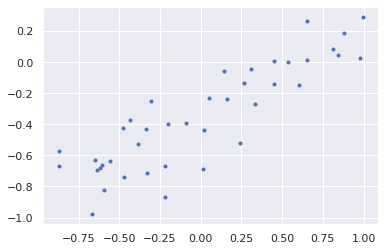

In [94]:
x = np.random.uniform(-1, 1, 100)
t = w0 + w1*x + np.random.normal(scale=var, size=100)
plt.plot(x[:40], t[:40], '.')

phi = np.ones((100, 2))
phi[:, 1] = x

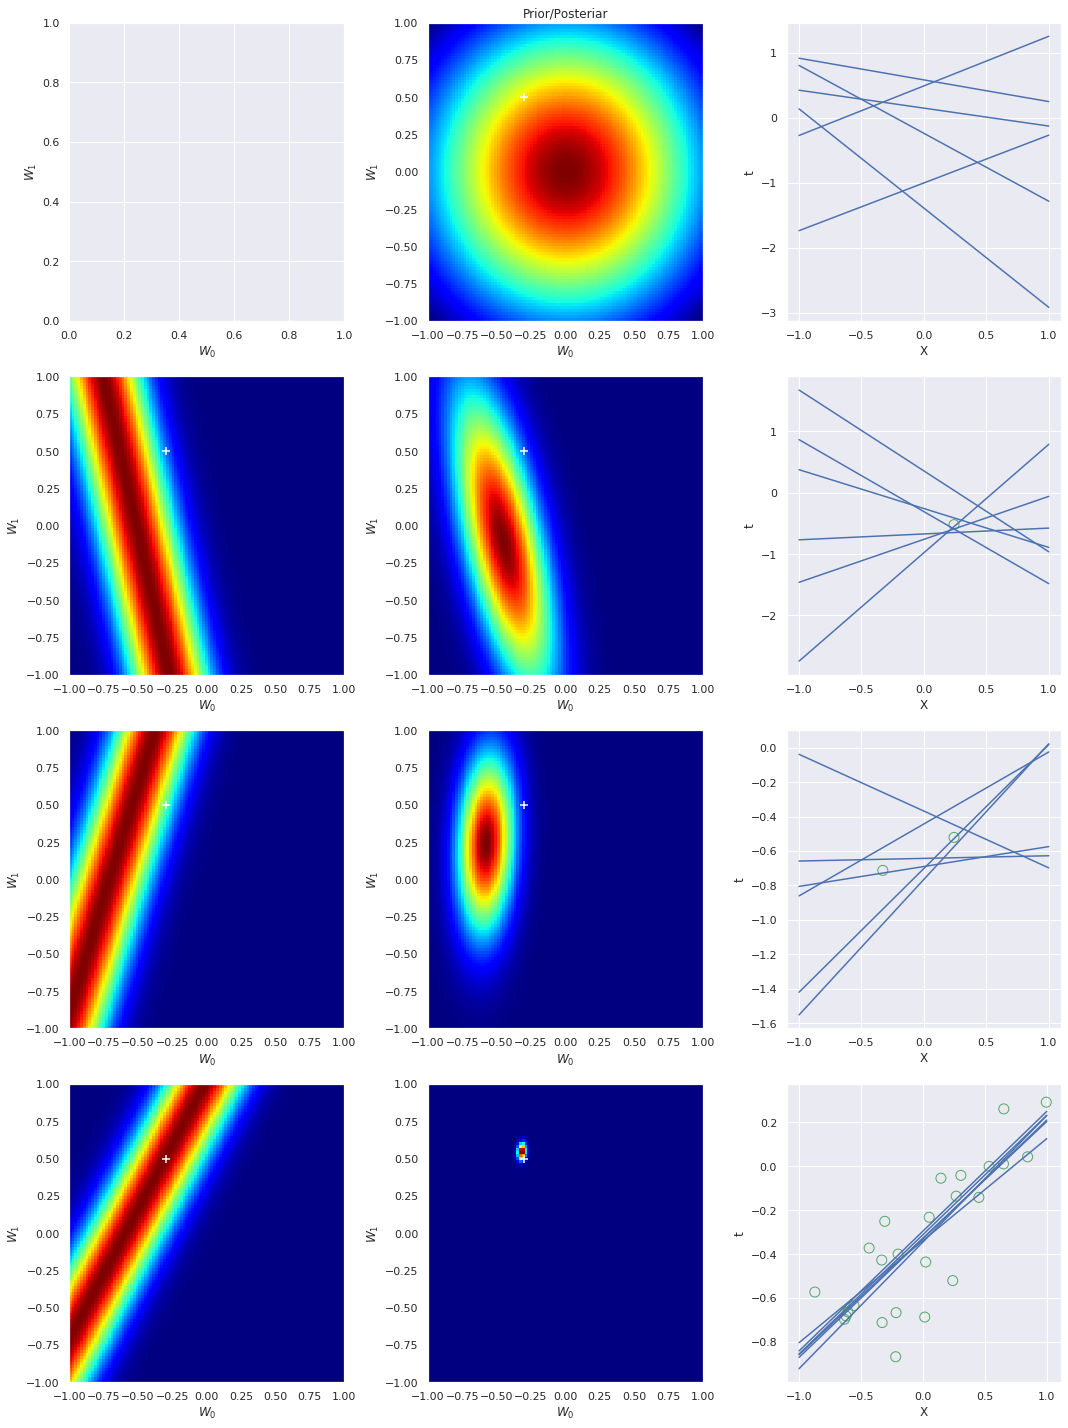

In [130]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
grid_w0, grid_w1 = np.mgrid[-1:1:100j, -1:1:100j]
pos = np.empty(grid_w0.shape + (2, ))
pos[:, :, 0] = grid_w0; pos[:, :, 1] = grid_w1

# prior is alpha = 2.0 => Sigma = 1/alpha * I
m_0 = [0, 0]
S_0, S_0_inv = np.eye(2)/alpha, np.eye(2)*alpha
p = sp.stats.multivariate_normal.pdf(pos, cov=S_0)
axs[0, 1].pcolormesh(grid_w0, grid_w1, p, cmap='jet')
axs[0, 1].scatter([w0], [w1], c='white', s=50, marker='+')
axs[0, 1].set_title("Prior/Posteriar")

w_sample = sp.stats.multivariate_normal.rvs(mean=m_0, cov=S_0, size=(6, ))
tmpx = np.linspace(-1, 1, 100)
for j in range(6):
    tmpy = tmpx * w_sample[j, 1] + w_sample[j, 0]
    axs[0, 2].plot(tmpx, tmpy, 'b')
        
for i in range(4):
    for j in range(2):
        axs[i, j].set_xlabel("$W_0$")
        axs[i, j].set_ylabel("$W_1$")
    axs[i, 2].set_xlabel("X")
    axs[i, 2].set_ylabel("t")

for i in range(0, 3):
    N = [1, 2, 100][i]
    phi_, t_ = phi[:N, :], t[:N]
    
    single_phi, single_t = phi[N-1], t[N-1]
    n_to_scatter = min(25, N)
    axs[i+1, 2].scatter(phi[:n_to_scatter, 1], t[:n_to_scatter], marker='o', facecolors='none', edgecolors='g', s=100)
    likelyhood = np.exp((-beta/2)*(single_t - pos @ single_phi)**2)*(beta/np.sqrt(2*np.pi))
    axs[i+1, 0].pcolormesh(grid_w0, grid_w1, likelyhood, cmap='jet')
    axs[i+1, 0].scatter([w0], [w1], s=50, c='white', marker='+')
    
    S_N = np.linalg.inv(S_0_inv + beta * np.matmul(phi_.T, phi_))
    m_N = np.matmul(S_N, beta * (phi_.T @ t_))
    axs[i+1, 1].pcolormesh(grid_w0, grid_w1, sp.stats.multivariate_normal.pdf(pos, mean=m_N, cov=S_N), cmap='jet')
    axs[i+1, 1].scatter([w0], [w1], s=50, c='white', marker='+')
    
    w_sample = sp.stats.multivariate_normal.rvs(mean=m_N, cov=S_N, size=(6, ))
    tmpx = np.linspace(-1, 1, 100)
    for j in range(6):
        tmpy = tmpx * w_sample[j, 1] + w_sample[j, 0]
        axs[i+1, 2].plot(tmpx, tmpy, 'b')
plt.tight_layout()